# Setting up a GA with DEAP

---

**Overview:** The goal of this document is to walk you through the setup of a genetic algorithm using [DEAP](https://deap.readthedocs.io/en/master/). The DEAP library is an optimization library in Python that can assist you with certain elements of the GA optimization. Below, I've listed the key elements of a typical GA. As you progress through the code that follows, it may be helpful for you to revisit these steps. Throughout this text, I will be using the Tor-ORd parameter recovery GA as an example.

1. **Initialize your population** – the purpose of this step is to define the starting parameters for all of the individuals in your initial population. For example, if my Tor-ORd parameter recovery has 100 individuals/generation, I will initialize generation 0 with 100 individuals. Each individual in this initial population will have conductance parameters set to a random value between 0.1x and 10x the baseline conductance. *It is key for you to randomly select these parameters using a uniform distribution, and if necessary, after performing a log transformation.* In this GA, I select my initial conductance parameters from a uniform distribution between -1 and 1. Then, I transform these values to conductance scalars with `10**x`, where `x` is the parameter value. This approach ensures that parameters are equally spread between scalars that will increase and decrease the conductance value.
2. **The natural selection loop** – This will continue for the specified number of generations
    - **Evaluate all individuals** – this step assigns a fitness score to every individual in the current generation's population (for gen 0, this will be the initial population). For example, the Tor-ORd parameter recovery GA compares each individual's AP and CaT feature values to the baseline Tor-ORd values. The output from this evaluation function is a number representing the difference between the individual and the baseline model.
    - **Select the best individuals** – Select the individuals that will mate to form the next generation. There are a few different ways that you can set this up in DEAP, but the most common approach is by using a tournament selection. With tournament selection, the GA will randomly select X number of individuals from your population and compare their fitness scores. The individual with the best fitness score will move into the mating pool, where its genes (i.e. parameter values) will propagate to the next generation. If there are 100 individuals/generation, there will be 100 tournaments of random individuals. 
    - **Mate the best individuals** – All of the individuals that won their tournament will be in the mating pool. The GA will randomly select two individuals (the parents) from the mating pool to mate to form two new individuals (the children). The parameter values of the children will consist of a random combination of paramater values from the parents. In the Tor-ORd GA, we randomly swap conductance values between the two parents to form the children.
    - **Mutate the children of the best individuals** – Before the children officially move into the new generation, they go through gene mutation. For each individual, there is a small probabiliy that each of their parameter values could be altered. The probability of mutation is set by you! In the Tor-ORd GA, there is a 20% chance that a parameter will be mutated. If it is mutated, it will be selected from a normal distribution centered around the current value, while ensuring the parameter value stays within the parameter bounds (e.g. 0.1x to 10x). The mutated children become the new population, and go the the beginning of the natural selection loop.
3. **Analyze your population** – It's important to save the parameter and fitness values for all individuals in each generation of the population. After the GA, you can get a sense of how well your GA performed by looking at the fitnesses of your best individuals, and if you're lucky enough to know the ground truth values (e.g. Tor-ORd parameter valuse of 1.0), their parameter values compared to the ground truth.


### The Code

Import libraries

In [1]:
import random
from math import log10
import matplotlib.pyplot as plt
from scipy.signal import find_peaks # pip install scipy
import seaborn as sns # pip install seaborn
from multiprocessing import Pool
import numpy as np
import pandas as pd

from deap import base, creator, tools # pip install deap
import myokit

from supercell_ga import Ga_Config, plot_generation

### Set up GA Hyperparameters

Before we initialize the individuals in generation 0, it's worth mentioning how to set the hyperparameters for the GA. A hyperparameter is a parameter that is used to define elements of the GA itself (e.g. `population_size`, `max_generations`), *but not* the parameters of the individuals themselves (e.g. conductances). The `GA_CONFIG` variable below is an instance of the `Ga_Config` class and contains a bunch of hyperparameters. You can find this class inside the `supercell_ga.py` file. I will reference these parameters throughout the Notebook. The `feature_targets` dictionary contains the 10th percentile, baseline, and 90th percentile values for the data used in the Tor-ORd model.

In [2]:
def start_ga(pop_size=20, max_generations=10):
    feature_targets = {'dvdt_max': [80, 86, 92],
                       'apd10': [5, 15, 30],
                       'apd50': [200, 220, 250],
                       'apd90': [250, 270, 300],
                       'cat_amp': [2.8E-4, 3.12E-4, 4E-4],
                       'cat10': [80, 100, 120],
                       'cat50': [200, 220, 240],
                       'cat90': [450, 470, 490]}

    # 1. Initializing GA hyperparameters
    global GA_CONFIG
    GA_CONFIG = Ga_Config(population_size=pop_size,
                          max_generations=max_generations,
                          params_lower_bound=0.1,
                          params_upper_bound=10,
                          tunable_parameters=['i_cal_pca_multiplier',
                                              'i_ks_multiplier',
                                              'i_kr_multiplier',
                                              'i_nal_multiplier',
                                              'jup_multiplier'],
                          mate_probability=0.9,
                          mutate_probability=0.9,
                          gene_swap_probability=0.2,
                          gene_mutation_probability=0.2,
                          tournament_size=2,
                          cost='function_1',
                          feature_targets=feature_targets)


### Initialize an individual

The function below will be used in the GA to initialize an individual. It randomly selects a value from a uniform distribution between -1 and 1, then raises 10 to the value. The function returns a dictionary of values between 0.1 and 10. An example output from this function would be:

```py
{
'i_cal_pca_multiplier': .58,
'i_ks_multiplier': 8.56,
'i_kr_multiplier': .23,
'i_nal_multiplier' 1.9,
'jup_multiplier': .87
}
```



In [3]:
def _initialize_individual():
    # Builds a list of parameters using random upper and lower bounds.
    lower_exp = log10(GA_CONFIG.params_lower_bound)
    upper_exp = log10(GA_CONFIG.params_upper_bound)
    initial_params = [10**random.uniform(lower_exp, upper_exp)
                      for i in range(0, len(
                          GA_CONFIG.tunable_parameters))]

    keys = [val for val in GA_CONFIG.tunable_parameters]
    return dict(zip(keys, initial_params))

### Evaluate an individual

The functions below will be used in the GA to evaluate an individual. The `_evaluate_fitness()` function accepts an individual as input, and returns a fitness score. 

Inside `_evaluate_fitness()` function, the individual is passes to the `get_feature_errors()` function. This function passes the individual to `get_normal_sim_dat()`, where the individual is simulated at 1 Hz pacing for 50,000 ms. The `get_normal_sim_dat()` function returns the time (`t`), voltage (`v`), intracellular calcium (`cai`), and ionic current (`i_ion`) for the simulated individual.

Back inside `get_feature_errors()`, the simulation data is compared to the AP and CaT data from the baseline model, `GA_CONFIG.feature_targets`.

In [4]:
def _evaluate_fitness(ind):
    feature_error = get_feature_errors(ind)

    # Returns 
    if feature_error == 500000:
        return feature_error

    #ead_fitness = get_ead_error(ind)
    fitness = feature_error #+ ead_fitness

    return fitness 


def get_feature_errors(ind):
    """
    Compares the simulation data for an individual to the baseline Tor-ORd values. 
    The returned error value is a sum of the differences between the individual and baseline values.

    Returns
    ------
        error
    """

    ap_features = {}
    t, v, cai, i_ion = get_normal_sim_dat(ind)

    # Returns really large error value if cell AP is not valid 
    if ((min(v) > -60) or (max(v) < 0)):
        return 500000 

    # Voltage/APD features#######################
    mdp = min(v)
    max_p = max(v)
    max_p_idx = np.argmax(v)
    apa = max_p - mdp
    dvdt_max = np.max(np.diff(v[0:30])/np.diff(t[0:30]))

    ap_features['dvdt_max'] = dvdt_max

    for apd_pct in [10, 50, 90]:
        repol_pot = max_p - apa * apd_pct/100
        idx_apd = np.argmin(np.abs(v[max_p_idx:] - repol_pot))
        apd_val = t[idx_apd+max_p_idx]

        ap_features[f'apd{apd_pct}'] = apd_val

    # Calcium/CaT features######################## 
    max_cai = np.max(cai)
    max_cai_idx = np.argmax(cai)
    cat_amp = np.max(cai) - np.min(cai)
    ap_features['cat_amp'] = cat_amp

    for cat_pct in [10, 50, 90]:
        cat_recov = max_cai - cat_amp * cat_pct / 100
        idx_catd = np.argmin(np.abs(cai[max_cai_idx:] - cat_recov))
        catd_val = t[idx_catd+max_cai_idx]

        ap_features[f'cat{cat_pct}'] = catd_val 

    error = 0

    if GA_CONFIG.cost == 'function_1':
        for k, v in ap_features.items():
            error += (GA_CONFIG.feature_targets[k][1] - v)**2
    else:
        for k, v in ap_features.items():
            if ((v < GA_CONFIG.feature_targets[k][0]) or
                    (v > GA_CONFIG.feature_targets[k][2])):
                error += 1000 

    return error


def get_normal_sim_dat(ind):
    """
        Runs simulation for a given individual. If the individuals is None,
        then it will run the baseline model

        Returns
        ------
            t, v, cai, i_ion
    """
    mod, proto, x = myokit.load('./tor_ord_endo.mmt')
    if ind is not None:
        for k, v in ind[0].items():
            mod['multipliers'][k].set_rhs(v)

    sim = myokit.Simulation(mod, proto)
    dat = sim.run(50000) # set time in ms

    # Get t, v, and cai for second to last AP#######################
    i_stim = dat['stimulus.i_stim']
    peaks = find_peaks(-np.array(i_stim), distance=100)[0]
    start_ap = peaks[-3] #TODO change start_ap to be after stim, not during
    end_ap = peaks[-2]

    t = np.array(dat['engine.time'][start_ap:end_ap])
    t = t - t[0]
    max_idx = np.argmin(np.abs(t-900))
    t = t[0:max_idx]
    end_ap = start_ap + max_idx

    v = np.array(dat['membrane.v'][start_ap:end_ap])
    cai = np.array(dat['intracellular_ions.cai'][start_ap:end_ap])
    i_ion = np.array(dat['membrane.i_ion'][start_ap:end_ap])

    return (t, v, cai, i_ion)

### Select the best individuals

You do not have to create a `_select()` function! DEAP will take care of this for you :) You'll see how this works when we get to the end of this tutorial.

### Mate

This function is used to create two children for the next generation. This code may be a little confusing, because there is nothing returned. Rather than creating two new child individuals, the parents swap parameters with some probability (`GA_CONFIG.gene_swap_probability`). Once these parameters are swapped, these two individuals are consider the "children."

In [5]:
def _mate(i_one, i_two):
    """Performs crossover between two individuals.

    There may be a possibility no parameters are swapped. This probability
    is controlled by `GA_CONFIG.gene_swap_probability`. Modifies
    both individuals in-place.

    Args:
        i_one: An individual in a population.
        i_two: Another individual in the population.
    """
    for key, val in i_one[0].items():
        if random.random() < GA_CONFIG.gene_swap_probability:
            i_one[0][key],\
                i_two[0][key] = (
                    i_two[0][key],
                    i_one[0][key])

### Mutate

This funciton accepts an individual as input. There is some probability (`GA_CONFIG.gene_mutation_probability`) that a given parameter will mutate. If it does, the new parameter will be selected from a normal distribution centered around the current value.

In [6]:
def _mutate(individual):
    """Performs a mutation on an individual in the population.

    Chooses random parameter values from the normal distribution centered
    around each of the original parameter values. Modifies individual
    in-place.

    Args:
        individual: An individual to be mutated.
    """
    keys = [k for k, v in individual[0].items()]

    for key in keys:
        if random.random() < GA_CONFIG.gene_mutation_probability:
            new_param = -1

            while ((new_param < GA_CONFIG.params_lower_bound) or
                   (new_param > GA_CONFIG.params_upper_bound)):
                new_param = np.random.normal(
                        individual[0][key],
                        individual[0][key] * .1)

            individual[0][key] = new_param


### Start the GA

The `start_ga()` function, already created above, needs to be updated to include all of the DEAP initialization steps. 

The first few lines are the same as above. In addition to what I write below, you can find a good overview and more thorough description in this [DEAP tutorial](https://deap.readthedocs.io/en/master/examples/ga_onemax.html).

The two lines with `creator.create()` are used to create the `Individual` class that is used to keep track of all individuals in the GA. The `toolbox` variable holds a DEAP `Toolbox()` object. The lines that follow are used to create and assign meaning to the following GA functions:
- `toolbox.init_param()` – Whenever this toolbox method is called, it will call the `_initialize_individual()` function that we created above.
- `toolbox.individiual()` – Will initialize an individual
- `toolbox.population()` – Will initialize a population
- `toolbox.evaluate()` – Will call the `_evaluate_fitness()` function
- `toolbox.select()` – This method will be used to select in the selection phase of the GA. In this GA, we use the `tools.selTournament` method to select individuals, and set the tournament size to `GA_CONFIG.tournament_size`, which is 2. This means that, to select an individual for mating, the GA will randomly select two individuals, and compare their fitness values – the individual with the higher fitness value will be selected for mating.
- `toolbox.mate()` – Will call the `_mate` function
- `toolbox.mutate()` – Will call the `_mutate` function
- `toolbox.map()` – you can either assign this the built-in `map` function or `p.map()`, a multi-threading map function. `p.map()` is recommended, because it is much faster.

Below this initialization, we call `run_ga()`, which will return the final population when it is complete. 

In [7]:
def start_ga(pop_size=20, max_generations=10):
    feature_targets = {'dvdt_max': [80, 86, 92],
                       'apd10': [5, 15, 30],
                       'apd50': [200, 220, 250],
                       'apd90': [250, 270, 300],
                       'cat_amp': [2.8E-4, 3.12E-4, 4E-4],
                       'cat10': [80, 100, 120],
                       'cat50': [200, 220, 240],
                       'cat90': [450, 470, 490]}

    # 1. Initializing GA hyperparameters
    global GA_CONFIG
    GA_CONFIG = Ga_Config(population_size=pop_size,
                          max_generations=max_generations,
                          params_lower_bound=0.1,
                          params_upper_bound=10,
                          tunable_parameters=['i_cal_pca_multiplier',
                                              'i_ks_multiplier',
                                              'i_kr_multiplier',
                                              'i_nal_multiplier',
                                              'jup_multiplier'],
                          mate_probability=0.9,
                          mutate_probability=0.9,
                          gene_swap_probability=0.2,
                          gene_mutation_probability=0.2,
                          tournament_size=2,
                          cost='function_1',
                          feature_targets=feature_targets)

    creator.create('FitnessMin', base.Fitness, weights=(-1.0,))

    creator.create('Individual', list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register('init_param',
                     _initialize_individual)
    toolbox.register('individual',
                     tools.initRepeat,
                     creator.Individual,
                     toolbox.init_param,
                     n=1)
    toolbox.register('population',
                     tools.initRepeat,
                     list,
                     toolbox.individual)

    toolbox.register('evaluate', _evaluate_fitness)
    toolbox.register('select',
                     tools.selTournament,
                     tournsize=GA_CONFIG.tournament_size)
    toolbox.register('mate', _mate)
    toolbox.register('mutate', _mutate)

    # To speed things up with multi-threading
    p = Pool()
    toolbox.register("map", p.map)

    # Use this if you don't want multi-threading
    #toolbox.register("map", map)

    # 2. Calling the GA to run
    final_population = run_ga(toolbox)

    return final_population

### Run the GA

The code below is commented step-by-step. 

Throughout this function, the DEAP `toolbox` object is used to call the functions initialized above (e.g. `.select()`, `.mate()`, `.mutate()`).

One thing that is worth mentioning before you dig into the code is how the `individual` objects store fitnesses and parameter values. A population is just a list, so if you want to access the first individual from a population and print out its fitness values, you would do something like:
```py
population[0].fitness # to get the fitness object
# OR
population[0].fitness.values[0] # to get the fitness value
```

The code above could print something like the following:
```
deap.creator.FitnessMin((45363.94399202937,))
# OR
45363.94399202937
```

The fitness for this random individual is equal to `45363.94399202937`. That's pretty bad.

If I wanted to access the parameter values for this same individual, I would do something like:
```py
population[0][0]
```
This code would print:
```py
{'i_cal_pca_multiplier': 0.14284092527579434, 
 'i_ks_multiplier': 4.359255228833062, 
 'i_kr_multiplier': 4.722062437408332,
 'i_nal_multiplier': 1.7968361194204527,
 'jup_multiplier': 1.8232088284951993}
```

These are the random parameter values selected for this individual.

In [8]:
def run_ga(toolbox):
    """
    Runs an instance of the genetic algorithm.

    Returns
    -------
        final_population : List[Individuals]
    """
    print('Evaluating initial population.')

    # 3. Calls _initialize_individuals GA_CONFIG.population size number of times and returns the initial population
    population = toolbox.population(GA_CONFIG.population_size)


    # 4. Calls _evaluate_fitness on every individual in the population
    fitnesses = toolbox.map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = (fit,)
        
    # Note: visualize individual fitnesses with: population[0].fitness
    gen_fitnesses = [ind.fitness.values[0] for ind in population]

    print(f'\tAvg fitness is: {np.mean(gen_fitnesses)}')
    print(f'\tBest fitness is {np.min(gen_fitnesses)}')

    # Store initial population details for result processing.
    final_population = [population]

    for generation in range(1, GA_CONFIG.max_generations):
        print('Generation {}'.format(generation))
        # Offspring are chosen through tournament selection. They are then
        # cloned, because they will be modified in-place later on.

        # 5. DEAP selects the individuals 
        selected_offspring = toolbox.select(population, len(population))

        offspring = [toolbox.clone(i) for i in selected_offspring]

        # 6. Mate the individualse by calling _mate()
        for i_one, i_two in zip(offspring[::2], offspring[1::2]):
            if random.random() < GA_CONFIG.mate_probability:
                toolbox.mate(i_one, i_two)
                del i_one.fitness.values
                del i_two.fitness.values

        # 7. Mutate the individualse by calling _mutate()
        for i in offspring:
            if random.random() < GA_CONFIG.mutate_probability:
                toolbox.mutate(i)
                del i.fitness.values

        # All individuals who were updated, either through crossover or
        # mutation, will be re-evaluated.
        
        # 8. Evaluating the offspring of the current generation
        updated_individuals = [i for i in offspring if not i.fitness.values]
        fitnesses = toolbox.map(toolbox.evaluate, updated_individuals)
        for ind, fit in zip(updated_individuals, fitnesses):
            ind.fitness.values = (fit,)

        population = offspring

        gen_fitnesses = [ind.fitness.values[0] for ind in population]

        print(f'\tAvg fitness is: {np.mean(gen_fitnesses)}')
        print(f'\tBest fitness is {np.min(gen_fitnesses)}')

        final_population.append(population)

    return final_population

### Let's give it a try

Evaluating initial population.
	Avg fitness is: 167693.86292372824
	Best fitness is 32539.75481873074
Generation 1
	Avg fitness is: 155287.61714740453
	Best fitness is 31761.570706042632


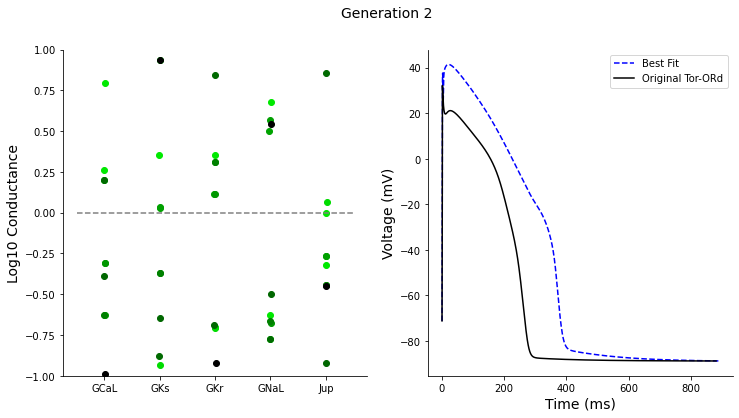

In [9]:
all_individuals = start_ga(pop_size=10, max_generations=2)

plot_generation(all_individuals,
                gen=None,
                is_top_ten=False,
                lower_bound=GA_CONFIG.params_lower_bound,
                upper_bound=GA_CONFIG.params_upper_bound)